In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import random
import cv2
import os
from tensorflow import keras
import keras_tuner

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
df_labels = pd.read_csv('train.csv')
data = 'train'

In [4]:
df_labels

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket
...,...,...
8222,903d2fffb3.jpg,Cricket
8223,b5f174c688.jpg,Badminton
8224,2433770a67.jpg,Tennis
8225,6403964166.jpg,Tennis


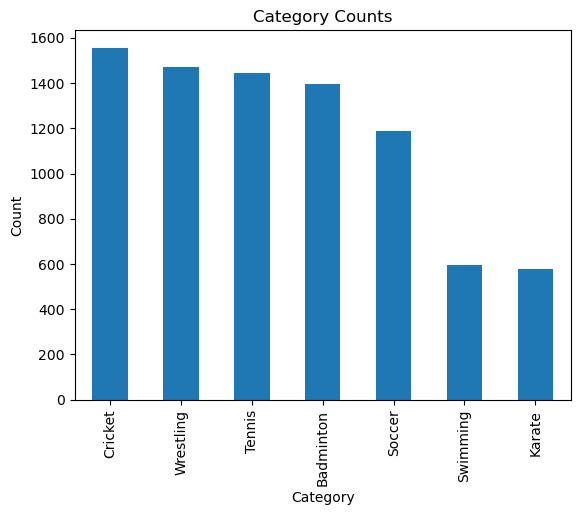

In [5]:
# Look at the class distribution
df_labels.label.value_counts().plot.bar()
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.show()

In [7]:
df_labels.label

0       Badminton
1       Badminton
2       Badminton
3       Badminton
4         Cricket
          ...    
8222      Cricket
8223    Badminton
8224       Tennis
8225       Tennis
8226     Swimming
Name: label, Length: 8227, dtype: object

In [12]:
df_labels.label

0       Badminton
1       Badminton
2       Badminton
3       Badminton
4         Cricket
          ...    
8222      Cricket
8223    Badminton
8224       Tennis
8225       Tennis
8226     Swimming
Name: label, Length: 8227, dtype: object

In [24]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# assume y_train is a numpy array of class labels and class_names is a list of class names
class_names = df_labels.label.unique()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df_labels.label), y=df_labels.label)

# create a dictionary that maps class indices to class weights
class_weight_dict = dict(zip(range(len(class_names)), class_weights))

# print the class weight dictionary
print(class_weight_dict)

{0: 0.8431030948964952, 1: 0.7553250091810503, 2: 2.033366287691547, 3: 0.9892977392977393, 4: 1.9752701080432173, 5: 0.8133465150766189, 6: 0.7989705739535787}


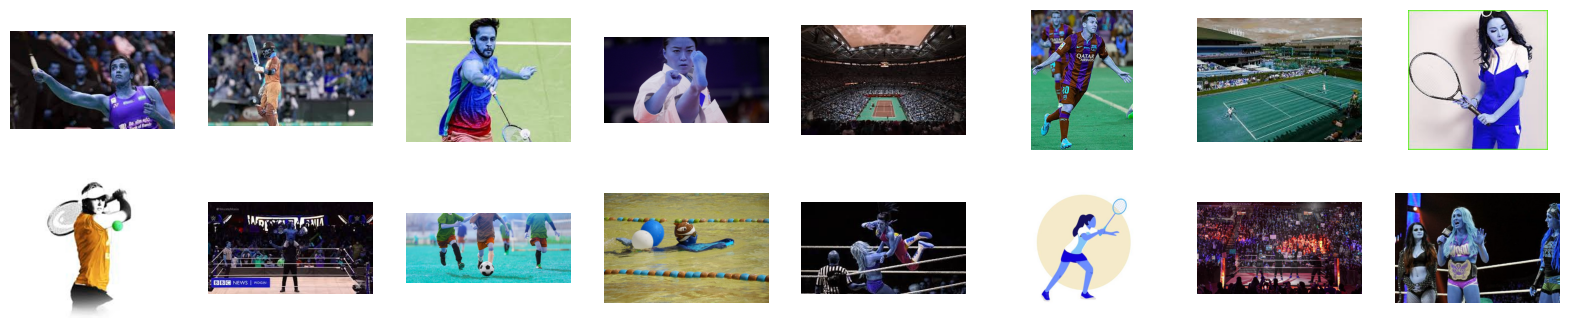

In [14]:
# Look at some random images from the dataset
rand_images = random.sample(os.listdir(data), 16)

fig = plt.figure(figsize=(20,4))
for i, im in enumerate(rand_images):
    plt.subplot(2, 8, i+1)
    im = cv2.imread(os.path.join(data, im))
    plt.imshow(im)
    plt.axis('off')
plt.show()

### Train/Test/Validation Split

In [15]:
train_split = 0.75
validation_split = 0.05

# Generate a random permutation of indices
idxs = np.random.permutation(range(len(df_labels)))

# Split the indices into training, validation, and testing sets
train_idxs = idxs[:int(train_split * len(idxs))] # first 75% of randomized idx's
val_idxs = idxs[int(train_split * len(idxs)):int((train_split + validation_split) * len(idxs))] # next 5% of randomized idx's
test_idxs = idxs[int((train_split + validation_split) * len(idxs)):] # remaining 20% of randomized idx's

# Split the labels into training, validation, and testing sets
train_labels = df_labels.iloc[train_idxs]
val_labels = df_labels.iloc[val_idxs]
test_labels = df_labels.iloc[test_idxs]

print("Size of training set:",len(train_idxs), "(", round((len(train_idxs)/len(idxs))*100), "% )")
print("Size of test set:",len(test_idxs), "(", round((len(test_idxs)/len(idxs))*100), "% )")
print("Size of validation set:",len(val_idxs), "(", round((len(val_idxs)/len(idxs))*100), "% )")

Size of training set: 6170 ( 75 % )
Size of test set: 1646 ( 20 % )
Size of validation set: 411 ( 5 % )


### Data Processing

#### Choose augmentations for the training data

In [16]:
# UPDATED AUGMENTATIONS (3/6/23)
# Augment the training generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.5,
    zoom_range = 0.5,
    rotation_range = 50,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True)

# Use consistent rescaling for validation and test generators
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255)

#### Show what the augmentations are doing

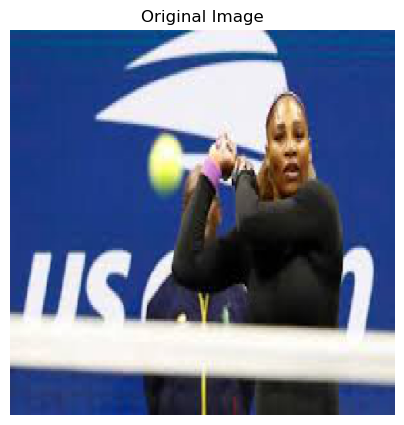

In [17]:
img = tf.keras.utils.load_img('train/00a87b6bb3.jpg', target_size = (500, 500))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Allows us to properly visualize our image by rescaling values in array
img_tensor /= 255.

#Plots image
plt.figure(figsize=(5, 5))
plt.imshow(img_tensor[0])
plt.axis('off')
plt.title('Original Image')
plt.show()

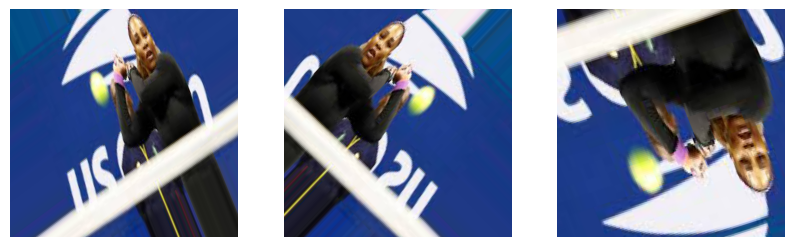

In [18]:
# Reload the image
img = tf.keras.utils.load_img('train/00a87b6bb3.jpg', target_size = (500, 500))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# Choose some augmentations
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range = 0.5,
    zoom_range = 0.5,
    rotation_range = 50,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True)

# Create our batch of one image
pic = datagen.flow(img_tensor, batch_size =1)
plt.figure(figsize=(10,8))

# Plot our figures
for i in range(1,4):
    plt.subplot(1, 3, i)
    batch = pic.next()
    image_ = batch[0].astype('uint8')
    plt.imshow(image_)
    plt.axis('off')

plt.show()

#### Create the generators

In [19]:
# Set batch size and image shape
batch_size = 32
img_shape = (64, 64)

train_generator = train_datagen.flow_from_dataframe(
    train_labels,
    directory = data,
    x_col = 'image_ID',
    y_col = 'label',
    class_mode = 'categorical',
    batch_size = batch_size,
    target_size = img_shape
)

test_generator = test_datagen.flow_from_dataframe(
    test_labels,
    directory = data,
    x_col = 'image_ID',
    y_col = 'label',
    class_mode = 'categorical',
    batch_size = batch_size,
    target_size = img_shape
)


validation_generator = validation_datagen.flow_from_dataframe(
    val_labels,
    directory = data,
    x_col = 'image_ID',
    y_col = 'label',
    class_mode = 'categorical',
    batch_size = batch_size,
    target_size = img_shape
)

Found 6170 validated image filenames belonging to 7 classes.
Found 1646 validated image filenames belonging to 7 classes.
Found 411 validated image filenames belonging to 7 classes.


### Build a CNN

In [20]:
# UPDATED MODEL (3/6/23)
# Define the model

activation = 'relu'
units = 64
rate = 0.5

classifier = Sequential()

classifier.add(Conv2D(
    filters = 32,
    kernel_size = (3, 3),
    activation = 'relu',
    input_shape = train_generator.image_shape))

classifier.add(MaxPooling2D(
    pool_size = (2, 2)))

classifier.add(Conv2D(
    filters = 64,
    kernel_size = (3, 3),
    activation = 'relu'))

classifier.add(MaxPooling2D(
    pool_size = (2, 2)))

classifier.add(Conv2D(
    filters = 128,
    kernel_size = (3, 3),
    activation = 'relu'))

classifier.add(MaxPooling2D(
    pool_size = (2, 2)))

classifier.add(Flatten())

# Add a Dropout layer to prevent overfitting 
classifier.add(Dropout(
    rate = rate))

classifier.add(Dense(
    units = units,
    activation = activation))

classifier.add(Dense(
    units = len(train_generator.class_indices),
    activation = 'softmax'))

# Compile the model
classifier.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = 'categorical_accuracy')

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

#### Fit the model on the training data, and evaluate its predictions on the test data

In [26]:
import time
st = time.time()

classifier.fit(
    x = train_generator,
    epochs = 10,
#    steps_per_epoch = 5,
    batch_size = 32,
    class_weight = class_weight_dict,
    validation_data = validation_generator)

et = time.time()
res = et - st
final_res = res / 60

print('\n')
print('Execution time:', final_res, 'minutes')
print('\n')

# Evaluate the model on the test data
test_loss, test_acc = classifier.evaluate(test_generator)
print('\n')
print("Model accuracy is", test_acc)

Epoch 1/10
193/193 [==============================] - 85s 435ms/step - loss: 1.6615 - categorical_accuracy: 0.2984 - val_loss: 1.4342 - val_categorical_accuracy: 0.4185
Epoch 2/10
193/193 [==============================] - 56s 288ms/step - loss: 1.3942 - categorical_accuracy: 0.4472 - val_loss: 1.3557 - val_categorical_accuracy: 0.4891
Epoch 3/10
193/193 [==============================] - 52s 269ms/step - loss: 1.3134 - categorical_accuracy: 0.4849 - val_loss: 1.2719 - val_categorical_accuracy: 0.5231
Epoch 4/10
193/193 [==============================] - 52s 271ms/step - loss: 1.2545 - categorical_accuracy: 0.5159 - val_loss: 1.1897 - val_categorical_accuracy: 0.5572
Epoch 5/10
193/193 [==============================] - 56s 293ms/step - loss: 1.2173 - categorical_accuracy: 0.5246 - val_loss: 1.1368 - val_categorical_accuracy: 0.5985
Epoch 6/10
193/193 [==============================] - 66s 343ms/step - loss: 1.1784 - categorical_accuracy: 0.5502 - val_loss: 1.3068 - val_categorical_acc

In [27]:
print("Model loss is", test_loss)

Model loss is 1.0144325494766235


#### Now evaluate its predictions on the training data

In [28]:
# Evaluate the model on the training data to check for overfitting
train_loss, train_acc = classifier.evaluate(train_generator)
print('\n')
print("Model accuracy is", train_acc)

193/193 [==============================] - 35s 179ms/step - loss: 0.9964 - categorical_accuracy: 0.6399


Model accuracy is 0.6398703455924988


### Hyperparameter Tuning using keras_tuner.RandomSearch()

#### Create a function that creates and returns a Keras model. Use the 'hp' argument to define the hyperparameters to try during model creation.

In [13]:
def build_model(hp):
    model = keras.Sequential()
    
    model.add(Conv2D(
        filters = 32,
        kernel_size = (3, 3),
        activation = 'relu',
        input_shape = train_generator.image_shape))

    model.add(MaxPooling2D(
        pool_size = (2, 2)))

    model.add(Conv2D(
        filters = 64,
        kernel_size = (3, 3),
        activation = 'relu'))

    model.add(MaxPooling2D(
        pool_size = (2, 2)))

    model.add(Conv2D(
        filters = 128,
        kernel_size = (3, 3),
        activation = 'relu'))

    model.add(MaxPooling2D(
        pool_size = (2, 2)))

    model.add(Flatten())

    # Add a Dropout layer to prevent overfitting 
    model.add(Dropout(
        rate = hp.Choice('rate', [0.2, 0.3, 0.4, 0.5])))

    model.add(Dense(
        units = hp.Choice('units', [8, 16, 32, 64]),
        activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])))

    model.add(Dense(
        units = len(train_generator.class_indices),
        activation = 'softmax'))

    # Compile the model
    model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics = 'categorical_accuracy')
    return model

In [15]:
# Initialize a RandomSearch tuner and specify the objective (and max_trials if we want)
tuner = keras_tuner.RandomSearch(
    build_model,
    max_trials = 5,
    objective = 'val_loss')

In [16]:
# Start the search and find the best model
import time
st = time.time()

tuner.search(
    train_generator,
    epochs = 10,
    steps_per_epoch = 10,
    validation_data = validation_generator)

best_model = tuner.get_best_models()[0]

et = time.time()
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

best_model = tuner.get_best_models()[0]

best_hyperparams = tuner.get_best_hyperparameters()[0]
best_hyperparams

Trial 5 Complete [00h 01m 09s]
val_loss: 1.7484718561172485

Best val_loss So Far: 1.6854221820831299
Total elapsed time: 00h 04m 54s
INFO:tensorflow:Oracle triggered exit
Execution time: 4.9125584125518795 minutes


In [18]:
best_hyperparams